In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pickle
from tensorflow import keras    
from tensorflow.keras.models import save_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report
from IPython.display import display, HTML

In [2]:
data = pd.read_csv("C:/Users/andri/Documents/Andri Martin/Trisakti/Semester 6/DBS_Coding-Camp2025/Capstone/1_1/Colab/Capstone_Akmal_Andri_Zahran/recipes_crop.csv")
data.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,"c(""Mix everything together and bring to a boil..."


In [3]:
columns = [
    'RecipeId', 'Name', 'CookTime', 'PrepTime', 'TotalTime',
    'RecipeIngredientParts', 'Calories', 'FatContent', 'SaturatedFatContent',
    'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
    'FiberContent', 'SugarContent', 'ProteinContent', 'RecipeServings', 'Keywords', 
    'Images'
]
data = data[columns]

In [4]:
def extract_quoted_strings(s):
    return re.findall(r'"([^"]*)"', s)

def clean_image_url(url_string):
    if isinstance(url_string, str):
        urls = extract_quoted_strings(url_string)
        if urls:
            return urls[0] 
    return None

data['Images'] = data['Images'].apply(clean_image_url)

In [5]:
CUISINE_KEYWORDS = {
    'Asian': [
        'asian', 'chinese', 'japanese', 'korean', 'thai', 'vietnamese',
        'indonesian', 'malaysian', 'filipino', 'indian', 'hunan', 'szechuan',
        'cantonese', 'mongolian', 'cambodian'
    ],
    'Western': [
        'american', 'canadian', 'australian', 'tex mex', 'pennsylvania dutch',
        'southwestern u.s.', 'hawaiian'
    ],
    'European': [
        'italian', 'french', 'german', 'spanish', 'greek', 'austrian',
        'belgian', 'danish', 'dutch', 'finnish', 'hungarian', 'icelandic',
        'norwegian', 'polish', 'portuguese', 'russian', 'scandinavian',
        'scottish', 'swedish', 'swiss', 'welsh', 'georgian', 'czech'
    ],
    'Middle Eastern': [
        'lebanese', 'turkish', 'moroccan', 'israeli', 'palestinian',
        'southwest asia (middle east)', 'iraqi', 'iranian', 'armenian'
    ],
    'Latin American': [
        'brazilian', 'mexican', 'peruvian', 'cuban', 'caribbean', 'chilean',
        'colombian', 'costa rican', 'ecuadorean', 'guatemalan', 'honduran',
        'puerto rican', 'venezuelan'
    ],
    'African': [
        'african', 'egyptian', 'ethiopian', 'nigerian', 'south african',
        'sudanese', 'somalian'
    ],
    'Other Cuisines': [
        'polynesian', 'native american', 'wild game', 'kosher', 'filipino',
        'nepalese', 'pakistani'
    ]
}

MEAL_TYPE_KEYWORDS = {
    'Breakfast': [
        'breakfast', 'pancake', 'oatmeal', 'eggs', 'brunch', 'eggs breakfast'
    ],
    'Lunch': [
        'lunch', 'salad', 'sandwich', 'light meal', 'lunch/snacks',
        'chicken stew', 'chicken stews'
    ],
    'Dinner': [
        'dinner', 'main course', 'meat', 'stew', 'poultry', 'one dish meal',
        'roast beef', 'meatloaf', 'steak', 'duck', 'goose', 'quail', 'pheasant',
        'rabbit', 'venison', 'lamb/sheep', 'veal', 'pork',
        'soup', 'bean soup', 'beef barley soup', 'chowders', 'clear soup', 
        'navy bean soup', 'stocks',
        'mashed potatoes', 'potato', 'yam/sweet potato', 'rice', 'brown rice',
        'white rice', 'long grain rice', 'medium grain rice', 'short grain rice',
        'vegetable', 'greens', 'collard greens', 'chard', 'spinach', 'cabbage',
        'cauliflower', 'onions', 'peppers', 'corn', 'beans', 'black beans',
        'lentil', 'grains'
    ],
    'Snack': [
        'snack', 'appetizer', 'smoothies', 'quick breads', 'shakes',
        'spreads', 'dips',
        'dessert', 'cake', 'cookie', 'pie', 'ice cream', 'chocolate chip cookies',
        'bar cookie', 'cookie & brownie', 'cheesecake', 'frozen desserts',
        'desserts easy', 'gelatin', 'candy'
    ]
}

DIET_KEYWORDS = {
    'Vegetarian': [
        'vegetarian', 'vegan', 'vegetable', 'soy/tofu', 'tempeh',
        'dairy free foods', 'egg free', 'lactose free'
    ],
    'Pescatarian': [
        'fish', 'seafood', 'salmon', 'tuna', 'halibut', 'bass', 'catfish',
        'tilapia', 'trout', 'whitefish', 'mahi mahi', 'orange roughy',
        'crab', 'lobster', 'mussels', 'oysters', 'squid', 'octopus',
        'crawfish', 'no shell fish'
    ],
    'Low Calorie': [
        'low calorie', 'healthy', 'light', 'low cholesterol', 'low protein',
        'very low carbs'
    ],
    'High Protein': [
        'high protein', 'protein', 'chicken breast', 'chicken livers',
        'beef organ meats', 'beef kidney', 'beef liver', 'turkey breasts',
        'duck breasts'
    ],
    'Special Diets': [  
        'high fiber', 'kid friendly', 'toddler friendly', 'beginner cook',
        'kosher', 'free of...', 'gluten free', 'dairy free', 'lactose free',
        'inexpensive', 'for large groups', 'camping', 'college food'
    ]
}

In [6]:
# Data preprocessing functions
def extract_multi_label_features(keywords, feature_dict):
    if pd.isna(keywords):
        return ['Other']
    keywords_lower = str(keywords).lower()
    matched_features = []
    
    for category, category_keywords in feature_dict.items():
        if any(kw in keywords_lower for kw in category_keywords):
            matched_features.append(category)
    
    return matched_features if matched_features else ['Other']

def get_single_label(features):
    return features[0] if features else 'Other'

def match_cuisine_preference(cuisine_pref, available_cuisines):
    if not cuisine_pref:
        return list(available_cuisines)
    
    pref_lower = cuisine_pref.lower()
    matched = []
    
    for cuisine, keywords in CUISINE_KEYWORDS.items():
        if (pref_lower == cuisine.lower()) or any(kw in pref_lower for kw in keywords):
            matched.append(cuisine)
    
    return matched if matched else list(available_cuisines)

In [7]:
def preprocess_data(df):
    df = df.drop_duplicates(subset=['RecipeId']).copy()
    
    # Convert time formats
    def convert_time(time_str):
        if pd.isna(time_str):
            return 0
        try:
            time_str = str(time_str).upper().replace('PT', '')
            total = 0
            if 'H' in time_str:
                h_part = time_str.split('H')[0]
                total += int(h_part) * 60
                time_str = time_str.split('H')[1]
            if 'M' in time_str:
                m_part = time_str.split('M')[0]
                total += int(m_part) if m_part else 0
            return total
        except:
            return 0
    
    for col in ['CookTime', 'PrepTime', 'TotalTime']:
        df[col] = df[col].apply(convert_time)
    
    # Normalize nutritional values per serving
    nut_cols = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
               'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
    
    for col in nut_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col] / df['RecipeServings'].replace(0, 1)
    
    # Add keyword-based features
    df['Cuisine'] = df['Keywords'].apply(
        lambda x: get_single_label(extract_multi_label_features(x, CUISINE_KEYWORDS)))
    
    df['MealType'] = df.apply(
        lambda row: get_single_label(
            extract_multi_label_features(
                str(row['Name']) + ' ' + str(row['Keywords']), 
                MEAL_TYPE_KEYWORDS
            )
        ), 
        axis=1
    )
    
    df['DietType'] = df['Keywords'].apply(
        lambda x: extract_multi_label_features(x, DIET_KEYWORDS)
    )
    
    # Fill missing values
    df['MealType'] = df['MealType'].fillna('Other')
    for col in nut_cols:
        df[col] = df[col].fillna(df[col].median())
    
    return df

In [8]:
# Process data
processed_data = preprocess_data(data)

# Prepare features for model training
feature_cols = ['Calories', 'ProteinContent', 'CarbohydrateContent', 'CookTime']
features = processed_data[feature_cols].values

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
processed_data['NormalizedFeatures'] = list(normalized_features)

In [9]:
# Prepare training data
def prepare_training_data(features, data):
    protein_high = data['ProteinContent'] > data['ProteinContent'].median()
    carb_low = data['CarbohydrateContent'] < data['CarbohydrateContent'].median()
    y = (protein_high & carb_low).astype(int)
    return train_test_split(features, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = prepare_training_data(normalized_features, processed_data)

In [10]:
# Build model
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    return model

In [11]:
# train model
model = build_model()
history = model.fit(
    X_train, y_train,  
    epochs= 20,
    batch_size=32,
    validation_data=(X_val, y_val),
)

Epoch 1/20


c:\Users\andri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3102/3102 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8190 - loss: 0.4712 - val_accuracy: 0.8760 - val_loss: 0.2839
Epoch 2/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8959 - loss: 0.2456 - val_accuracy: 0.9528 - val_loss: 0.1343
Epoch 3/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9517 - loss: 0.1307 - val_accuracy: 0.9702 - val_loss: 0.0876
Epoch 4/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9649 - loss: 0.0938 - val_accuracy: 0.9687 - val_loss: 0.0712
Epoch 5/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9708 - loss: 0.0743 - val_accuracy: 0.9718 - val_loss: 0.0619
Epoch 6/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9725 - loss: 0.0692 - val_accuracy: 0.9878 - val_loss: 0.0459
Epoch 7/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9747 - loss: 0.0628 - val_accuracy: 0.9730 - val_loss: 0.0646
Epoch 8/20
3102/3102 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9779 - loss: 0.0566 - val_accurac

In [12]:
# Evaluation
y_pred = (model.predict(X_val) > 0.5).astype(int)
print(classification_report(y_val, y_pred))

1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     34867
           1       0.99      0.91      0.95      7670

    accuracy                           0.98     42537
   macro avg       0.99      0.95      0.97     42537
weighted avg       0.98      0.98      0.98     42537



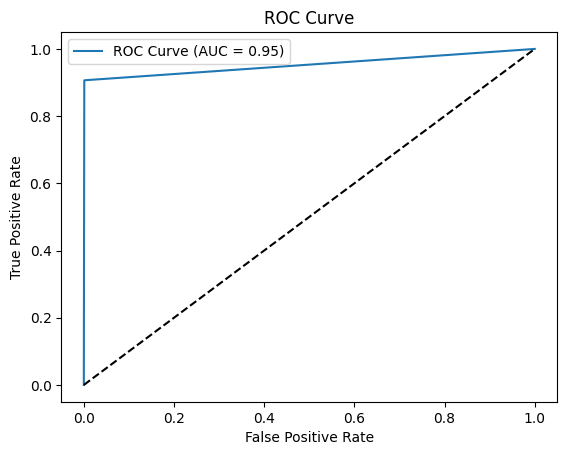

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

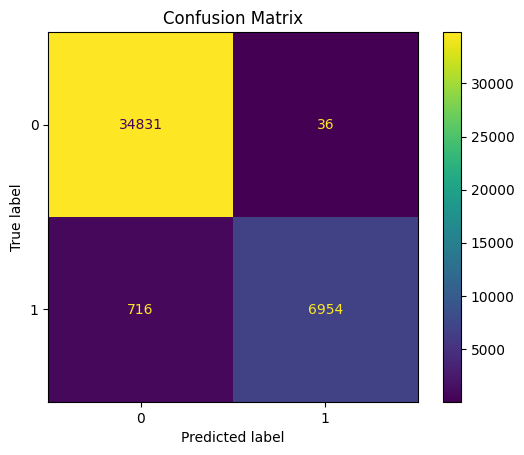

In [14]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Save model h5
save_model(model, 'food_recommendation_model.h5')

In [16]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [17]:
# Enhanced recommendation function
def recommend_recipes(model, data, calorie_target, cuisine_pref, meal_type, diet_pref=None, n=3, goal=None):
    try:
        # Get prediction scores for all recipes
        features_array = np.array(data['NormalizedFeatures'].tolist())
        scores = model.predict(features_array, verbose=0)
        data = data.copy()
        data['Score'] = scores.flatten()
        
        # Filter cuisine - with fallback
        available_cuisines = data['Cuisine'].unique()
        cuisine_matches = match_cuisine_preference(cuisine_pref, available_cuisines)
        filtered_data = data[data['Cuisine'].isin(cuisine_matches)].copy()
        
        if len(filtered_data) == 0:
            filtered_data = data.copy()
            print(f"⚠ No {cuisine_pref} cuisine found, showing all cuisines")
        
        # Filter diet - with fallback
        if diet_pref:
            diet_matches = extract_multi_label_features(diet_pref, DIET_KEYWORDS)
            diet_filtered = filtered_data[
                filtered_data['DietType'].apply(lambda x: any(d in diet_matches for d in x))
            ]
            
            if len(diet_filtered) > 0:
                filtered_data = diet_filtered
            else:
                print(f"⚠ No {diet_pref} diet found, ignoring diet filter")
        
        # Filter meal type with flexible matching
        meal_data = filtered_data[filtered_data['MealType'] == meal_type].copy()
        
        if len(meal_data) == 0:
            # Try similar meal types
            similar_types = {
                'Breakfast': ['Brunch'],
                'Lunch': ['Dinner', 'Main Course'],
                'Dinner': ['Lunch', 'Main Course'],
                'Snack': ['Appetizer', 'Dessert']
            }.get(meal_type, [])
            
            for similar in similar_types:
                meal_data = filtered_data[filtered_data['MealType'] == similar]
                if len(meal_data) > 0:
                    print(f"⚠ No {meal_type} found, showing {similar} instead")
                    break
        
        # Filter calories with flexible range
        if len(meal_data) > 0:
            calorie_filtered = meal_data[
                meal_data['Calories'].between(calorie_target * 0.7, calorie_target * 1.3)
            ]
            if len(calorie_filtered) > 0:
                meal_data = calorie_filtered
            else:
                meal_data = meal_data[
                    meal_data['Calories'].between(calorie_target * 0.5, calorie_target * 2)
                ]
                print(f"⚠ Adjusted calorie range for {meal_type}")
        
        # Final fallback if still empty
        if len(meal_data) == 0:
            print(f"⚠ No perfect matches for {meal_type}, showing closest options")
            meal_data = filtered_data.copy()
            meal_data['CalorieDiff'] = abs(meal_data['Calories'] - calorie_target)
        else:
            meal_data['CalorieDiff'] = abs(meal_data['Calories'] - calorie_target)
        
        # 🔽 Sort based on goal
        if goal == 5:  # Weight gain
            meal_data = meal_data.sort_values(['Calories', 'Score'], ascending=[False, False])
        else:  # Default: prioritize closest to target calories and high score
            meal_data = meal_data.sort_values(['CalorieDiff', 'Score'], ascending=[True, False])
        
        return meal_data.head(n)
    
    except Exception as e:
        print(f"⚠ Error recommending {meal_type}: {str(e)}")
        return pd.DataFrame()


In [18]:
# Inputan user interface
def get_user_input():
    print("\n=== Food Recommendation System ===")
    print("Please enter your information:")
    
    while True:
        try:
            gender = input("Gender (Male/Female): ").strip().capitalize()
            if gender not in ['Male', 'Female']:
                raise ValueError("Please enter Male or Female")
                
            age = int(input("Age (years): "))
            height = float(input("Height (cm): "))
            weight = float(input("Weight (kg): "))
            
            print("\nActivity Level:")
            print("1: Sedentary (little or no exercise)")
            print("2: Lightly active (light exercise 1-3 days/week)")
            print("3: Moderately active (moderate exercise 3-5 days/week)")
            print("4: Very active (hard exercise 6-7 days/week)")
            print("5: Extra active (very hard exercise & physical job)")
            activity = int(input("Tingkat aktivitas fisik (1-5)"))
            if activity not in range(1, 6):
                raise ValueError("Please choose 1-5")
            
            print("\nGoal:")
            print("1: Maintain weight")
            print("2: Mild weight loss (0.25 kg/week)")
            print("3: Weight loss (0.5 kg/week)")
            print("4: Extreme weight loss (1 kg/week)")
            print("5: Weight gain")
            goal = int(input("Goals (1: Maintain, 2: Mild Loss, 3: Weight Loss, 4: Extreme Loss, 5: Weight Gain)"))
            if goal not in range(1, 6):
                raise ValueError("Please choose 1-5")
            
            cuisine = input("Cuisine preference (e.g., European, Asian, dan lainnya): ").strip().capitalize()
            diet = input("Diet preference (e.g., Vegetarian, High Protein, or leave blank): ").strip().capitalize() or None
            
            meals_per_day = int(input("Meals per day (3-5): "))
            if meals_per_day not in range(3, 6):
                raise ValueError("Please enter 3-5")
            
            return {
                'gender': gender,
                'age': age,
                'height': height,
                'weight': weight,
                'activity': activity,
                'goal': goal,
                'cuisine_preference': cuisine,
                'diet_preference': diet,
                'meals_per_day': meals_per_day
            }
        except ValueError as e:
            print(f"Invalid input: {e}. Please try again.")

In [19]:
def calculate_calorie_needs(user):
    # Hitung BMR menggunakan rumus Mifflin-St Jeor yang lebih akurat
    if user['gender'] == 'Male':
        bmr = (10 * user['weight']) + (6.25 * user['height']) - (5 * user['age']) + 5
    else:
        bmr = (10 * user['weight']) + (6.25 * user['height']) - (5 * user['age']) - 161

    # Penyesuaian level aktivitas
    activity_mult = {
        1: 1.2,    # Sedentary
        2: 1.375,  # Lightly active
        3: 1.55,   # Moderately active
        4: 1.725,  # Very active
        5: 1.9     # Extra active
    }[user['activity']]

    # Penambahan kalori berdasarkan goal
    goal_adjustment = {
        1: 0,     # Maintain
        2: -250,  # Mild loss
        3: -500,  # Weight loss
        4: -750,  # Extreme loss
        5: 500    # Weight gain
    }[user['goal']]

    return (bmr * activity_mult) + goal_adjustment
    
def print_meal_recommendation(meal_name, meal_data):
    if len(meal_data) == 0:
        print(f"\nNo {meal_name} recommendations available")
        return
    
    print(f"\n=== {meal_name} Recommendations ===")
    for idx, (_, row) in enumerate(meal_data.iterrows(), 1):
        print(f"\n{idx}. {row['Name']}")
        print(f"   Cuisine: {row['Cuisine']}")
        print(f"   Meal Type: {row['MealType']}")
        print(f"   Calories: {row['Calories']:.0f} kcal")
        print(f"   Protein: {row['ProteinContent']:.1f}g")
        print(f"   Carbs: {row['CarbohydrateContent']:.1f}g")
        print(f"   Diet Tags: {', '.join(row['DietType']) if isinstance(row['DietType'], list) else row['DietType']}")
        
        if pd.notna(row['Images']) and str(row['Images']).startswith('http'):
            try:
                display(HTML(f'<img src="{row["Images"]}" width="300">'))
            except:
                print("   [Image unavailable]")
        else:
            print("   [No image available]")

In [20]:
def calculate_calorie_needs(user):
    """
    Menghitung kebutuhan kalori harian berdasarkan rumus Harris-Benedict.
    """
    if user['gender'] == 'male':
        bmr = 10 * user['weight'] + 6.25 * user['height'] - 5 * user['age'] + 5
    else:
        bmr = 10 * user['weight'] + 6.25 * user['height'] - 5 * user['age'] - 161

    activity_multiplier = {
        'sedentary': 1.2,
        'light': 1.375,
        'moderate': 1.55,
        'active': 1.725
    }

    return bmr * activity_multiplier.get(user['activity_level'], 1.2)


def generate_recommendations():
    # Static user input
    user = {
        'height': 165,  # in cm
        'weight': 50,   # in kg
        'age': 22,
        'gender': 'male',
        'activity_level': 'light',  # could be: 'sedentary', 'light', 'moderate', 'active'
        'meals_per_day': 3,
        'cuisine_preference': 'Asian',
        'diet_preference': None,  # could be: None, 'Vegetarian', 'Vegan', etc.
        'goal': 'weight_gain'     # could be: 'weight_loss', 'maintenance', 'weight_gain'
    }

    # Calculate nutritional needs
    height_m = user['height'] / 100
    bmi = user['weight'] / (height_m ** 2)
    bmi_category = ("Underweight" if bmi < 18.5 else
                    "Normal" if bmi < 25 else
                    "Overweight" if bmi < 30 else
                    "Obese")

    base_calories = calculate_calorie_needs(user)

    # Adjust based on goal
    goal_map = {'weight_loss': 1, 'maintenance': 3, 'weight_gain': 5}
    goal_code = goal_map.get(user['goal'], 3)

    if user['goal'] == 'weight_loss':
        target_calories = base_calories - 500
    elif user['goal'] == 'weight_gain':
        target_calories = base_calories + 500
    else:
        target_calories = base_calories

    print("\n=== Your Nutritional Profile ===")
    print(f"BMI: {bmi:.1f} ({bmi_category})")
    print(f"Daily Calorie Target: {target_calories:.0f} kcal ({user['goal'].replace('_', ' ').title()})")

    # Calculate meal calorie distribution
    if user['meals_per_day'] == 3:
        meal_calories = {
            'Breakfast': target_calories * 0.3,
            'Lunch': target_calories * 0.4,
            'Dinner': target_calories * 0.3
        }
    elif user['meals_per_day'] == 4:
        meal_calories = {
            'Breakfast': target_calories * 0.25,
            'Lunch': target_calories * 0.35,
            'Dinner': target_calories * 0.3,
            'Snack': target_calories * 0.1
        }
    else:  # 5 meals
        if user['goal'] == 'weight_gain':
            meal_calories = {
                'Breakfast': target_calories * 0.25,
                'Morning Snack': target_calories * 0.15,
                'Lunch': target_calories * 0.3,
                'Afternoon Snack': target_calories * 0.1,
                'Dinner': target_calories * 0.2
            }
        else:
            meal_calories = {
                'Breakfast': target_calories * 0.2,
                'Morning Snack': target_calories * 0.1,
                'Lunch': target_calories * 0.3,
                'Afternoon Snack': target_calories * 0.1,
                'Dinner': target_calories * 0.3
            }

    # Generate recommendations
    print("\n=== Generating Meal Recommendations ===")
    recommendations = {}

    for meal_type, calories in meal_calories.items():
        rec = recommend_recipes(
            model=model,
            data=processed_data,
            calorie_target=calories,
            cuisine_pref=user['cuisine_preference'],
            meal_type=meal_type.split()[-1],
            diet_pref=user['diet_preference'] if user['diet_preference'] != 'None' else None,
            n=3,
            goal=goal_code
        )

        if len(rec) > 0:
            recommendations[meal_type] = rec

    # Display results
    if not recommendations:
        print("\n⚠ No recommendations could be generated with your current preferences.")
        print("Try adjusting your cuisine or diet preferences.")
        return

    print("\n=== Your Personalized Meal Plan ===")
    for meal_type, meal_data in recommendations.items():
        print_meal_recommendation(meal_type, meal_data)

    # Nutrition Summary
    print("\n=== Nutrition Summary ===")
    total_cal = 0
    for meal_type, meal_data in recommendations.items():
        if not meal_data.empty:
            meal_avg_cal = meal_data['Calories'].mean()
            total_cal += meal_avg_cal
            print(f"{meal_type} (Avg): {meal_avg_cal:.0f} kcal")

    print(f"\nTotal Estimated Calories: {total_cal:.0f} kcal")

    deviation = abs(total_cal - target_calories) / target_calories * 100
    diff = total_cal - target_calories

    if deviation > 15:
        print(f"⚠ Warning: Total differs by {deviation:.1f}% from target. Consider portion adjustments.")
    else:
        print("✅ Total is within acceptable range of target.")

    # Goal-based narrative
    if user['goal'] == 'weight_gain':
        if diff > 0:
            print(f"💡 Good news! Your plan provides {diff:.0f} kcal more than your target.")
            print("This can support your weight gain goal effectively.")
        elif diff < 0:
            print(f"⚠ Your current plan falls short by {abs(diff):.0f} kcal.")
            print("Consider adding calorie-dense snacks or increasing portion sizes.")
    elif user['goal'] == 'weight_loss':
        if diff < 0:
            print(f"💡 Great! Your meal plan is {abs(diff):.0f} kcal below your target.")
            print("This may help you reduce weight gradually.")
        elif diff > 0:
            print(f"⚠ Your plan exceeds your target by {diff:.0f} kcal.")
            print("Consider reducing portion sizes or choosing lower-calorie foods.")
    else:  # maintenance
        if deviation <= 10:
            print("💡 Your meal plan is well balanced for weight maintenance.")
        elif diff > 0:
            print(f"⚠ Slightly above your target by {diff:.0f} kcal. Watch for gradual weight gain.")
        else:
            print(f"⚠ Slightly below your target by {abs(diff):.0f} kcal. You may experience mild weight loss.")


# Run the system
if __name__ == "__main__":
    generate_recommendations()



=== Your Nutritional Profile ===
BMI: 18.4 (Underweight)
Daily Calorie Target: 2461 kcal (Weight Gain)

=== Generating Meal Recommendations ===

=== Your Personalized Meal Plan ===

=== Breakfast Recommendations ===

1. Baked Salmon Roll With a Sweet Ponzu Sauce
   Cuisine: Asian
   Meal Type: Breakfast
   Calories: 842 kcal
   Protein: 25.8g
   Carbs: 129.3g
   Diet Tags: Vegetarian



2. Aaloo Chaat (tangy Potatoes)
   Cuisine: Asian
   Meal Type: Breakfast
   Calories: 766 kcal
   Protein: 14.5g
   Carbs: 120.2g
   Diet Tags: Vegetarian
   [No image available]

3. Bedouin Fresh Date Sweet (Rangina) (Gluten Free)
   Cuisine: Asian
   Meal Type: Breakfast
   Calories: 726 kcal
   Protein: 3.8g
   Carbs: 65.2g
   Diet Tags: Vegetarian, Low Calorie, High Protein, Special Diets



=== Lunch Recommendations ===

1. Udon Stir-Fry
   Cuisine: Asian
   Meal Type: Lunch
   Calories: 1094 kcal
   Protein: 46.4g
   Carbs: 192.8g
   Diet Tags: Vegetarian, Low Calorie, Special Diets
   [No image available]

2. Adam's Laksa for One
   Cuisine: Asian
   Meal Type: Lunch
   Calories: 1012 kcal
   Protein: 43.2g
   Carbs: 68.6g
   Diet Tags: Vegetarian
   [No image available]

3. Thai Chicken Sandwich
   Cuisine: Asian
   Meal Type: Lunch
   Calories: 781 kcal
   Protein: 26.1g
   Carbs: 24.0g
   Diet Tags: Other



=== Dinner Recommendations ===

1. Wontons
   Cuisine: Asian
   Meal Type: Dinner
   Calories: 946 kcal
   Protein: 66.8g
   Carbs: 141.2g
   Diet Tags: Low Calorie, High Protein, Special Diets
   [No image available]

2. Thai Chicken
   Cuisine: Asian
   Meal Type: Dinner
   Calories: 927 kcal
   Protein: 50.2g
   Carbs: 90.5g
   Diet Tags: Other



3. California Roll
   Cuisine: Asian
   Meal Type: Dinner
   Calories: 904 kcal
   Protein: 23.4g
   Carbs: 165.1g
   Diet Tags: Vegetarian, Special Diets



=== Nutrition Summary ===
Breakfast (Avg): 778 kcal
Lunch (Avg): 962 kcal
Dinner (Avg): 926 kcal

Total Estimated Calories: 2666 kcal
✅ Total is within acceptable range of target.
💡 Good news! Your plan provides 205 kcal more than your target.
This can support your weight gain goal effectively.
